In [1]:
import numpy as np
import pandas as pd
import datetime
from itertools import product

from scipy import stats
import statsmodels.api as sm
#from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [5]:
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """
    В коллабе работает, локально нет, поэтому перенес реализацию из sklearn
    """
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            multioutput = None

    return np.average(output_errors, weights=multioutput)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
df = pd.read_csv('data/ads_hour.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y %H:%M')
df.head()

Date    ads
0 2017-08-03 00:00:00  49136
1 2017-08-03 01:00:00  46450
2 2017-08-03 02:00:00  46355
3 2017-08-03 03:00:00  43748
4 2017-08-03 04:00:00  42281

### Train test split (в test последние 30% наблюдений)

In [8]:
TEST_FRAC = 0.3

train_size = int(np.ceil(df.shape[0] * (1 - TEST_FRAC)))
train_df = df[:train_size]
test_df = df[train_size:]

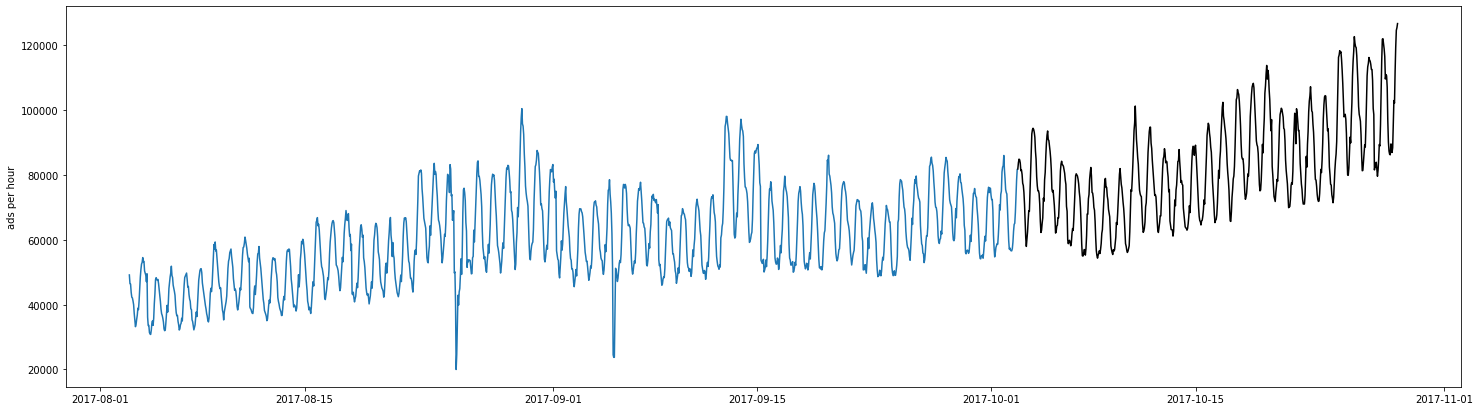

In [9]:
plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads'])
plt.plot(test_df['Date'], test_df['ads'], color='#000000')

plt.ylabel('ads per hour')
plt.show()

### Дальше работаем только с train

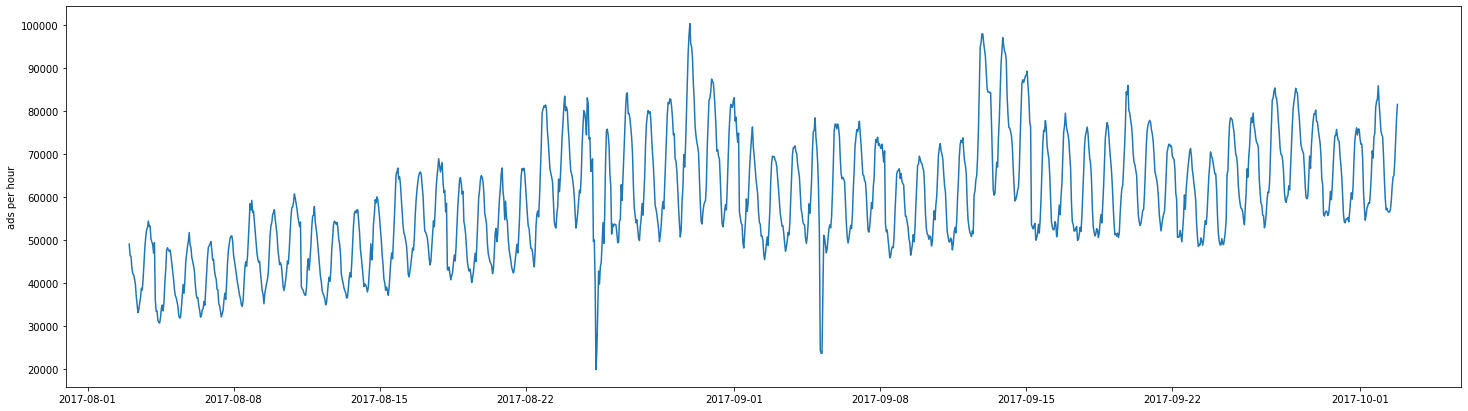

In [10]:
plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads'])

plt.ylabel('ads per hour')
plt.show()

### Преобразование Бокса-Кокса, чтобы избавиться от увеличения разброса таргета на более поздних периодах

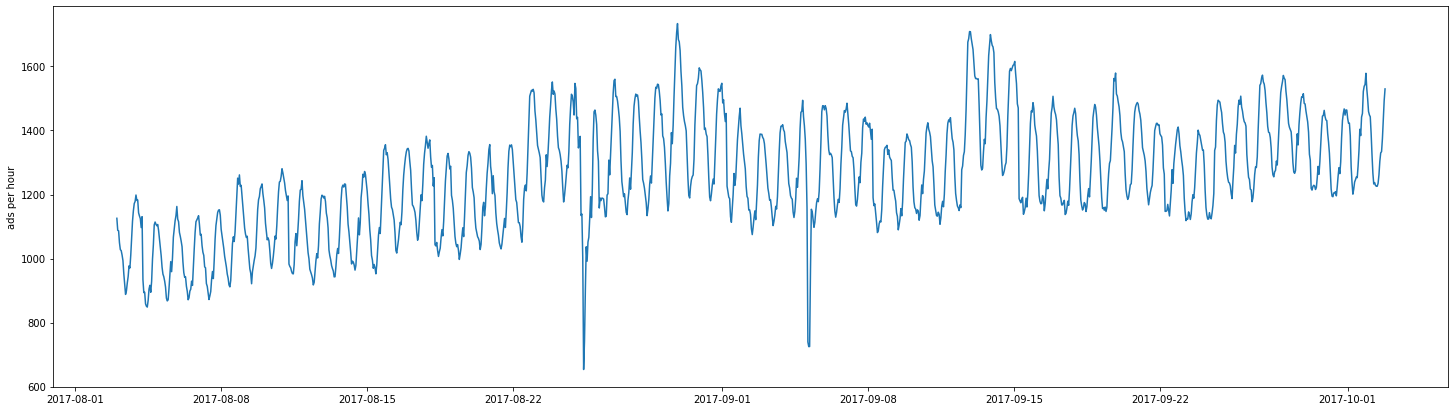

In [11]:
train_df['ads_bcox'], lmbd = stats.boxcox(train_df['ads'])

plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads_bcox'])

plt.ylabel('ads per hour')
plt.show()

### Простое дифференцирование

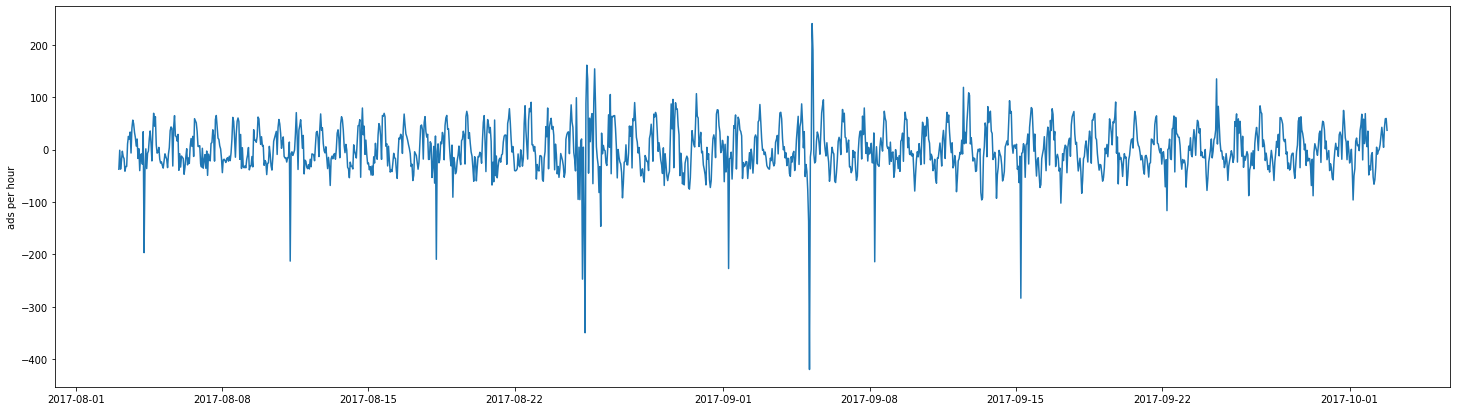

In [12]:
train_df['ads_bcox_diff'] = train_df['ads_bcox'] - train_df['ads_bcox'].shift(1)

plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads_bcox_diff'])
plt.ylabel('ads per hour')
plt.show()

### Сезонное дифференцирование (24 часа)

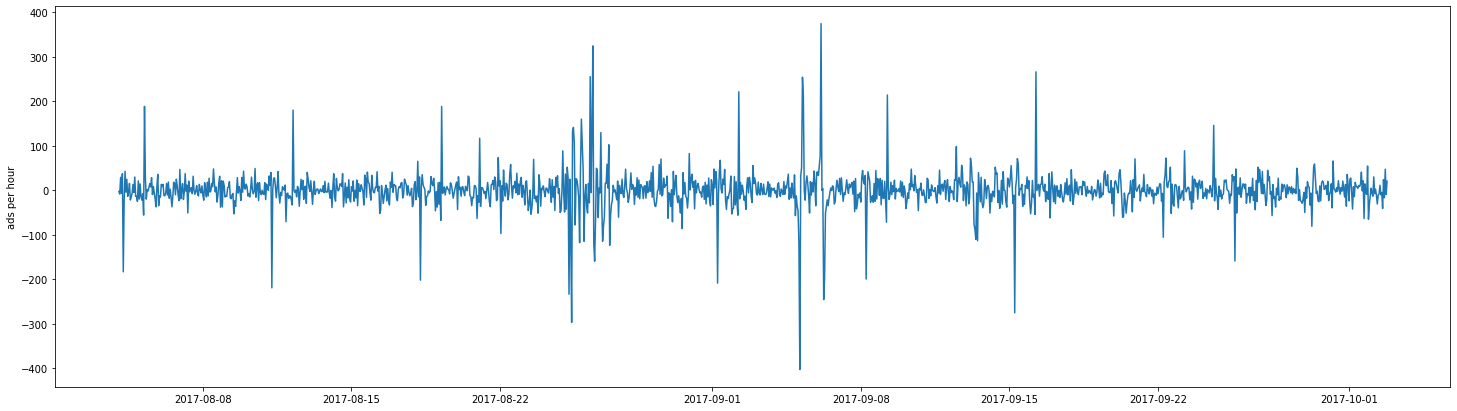

In [13]:
train_df['ads_bcox_diff_day'] = train_df['ads_bcox_diff'] - train_df['ads_bcox_diff'].shift(24)

plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads_bcox_diff_day'])
plt.ylabel('ads per hour')
plt.show()

С циклом в неделю тоже есть закономерность (пики с падением, и через какое-то время ростом в начале недели)

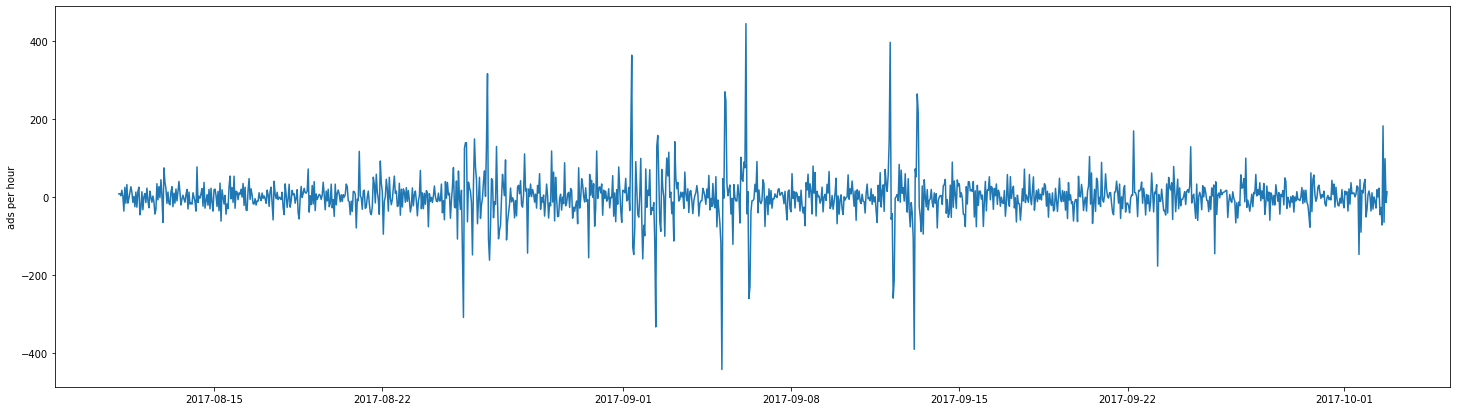

In [14]:
train_df['ads_bcox_diff_week'] = train_df['ads_bcox_diff_day'] - train_df['ads_bcox_diff_day'].shift(24*7)

plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads_bcox_diff_week'])
plt.ylabel('ads per hour')
plt.show()

### Автокорреляции

In [15]:
train_df['ads_bcox_diff_week'].head(24*7+24+1+1)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
189         NaN
190         NaN
191         NaN
192         NaN
193    8.234436
Name: ads_bcox_diff_week, Length: 194, dtype: float64

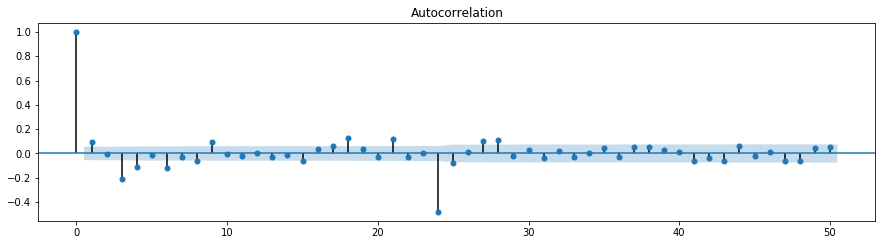

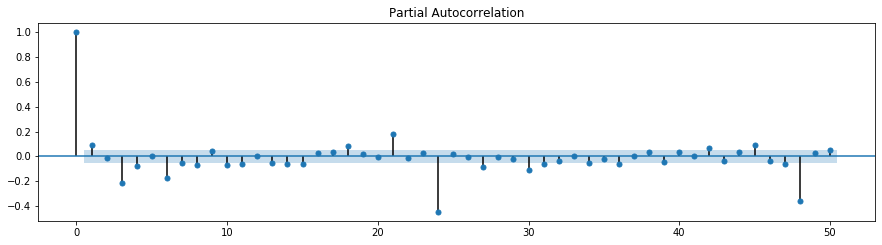

In [16]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df['ads_bcox_diff_week'][24*7+24+1+1:], lags=50, ax=ax)
plt.show()

plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df['ads_bcox_diff_week'][24*7+24+1+1:], lags=50, ax=ax)
plt.show()

### Поиск лучшей модели

In [17]:
ps = range(0, 3+1)
d=1
qs = range(0, 3+1)

Ps = range(0, 2+1)
D=1
Qs = range(0, 1+1)

In [18]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [ ]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['ads_bcox'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24, 24*7)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2h 16min 16s, sys: 1h 34s, total: 3h 16min 51s
Wall time: 1h 44min 49s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
93  (3, 3, 1, 1)  13931.934639
45  (1, 3, 1, 1)  13933.957549
95  (3, 3, 2, 1)  13934.575365
91  (3, 3, 0, 1)  13935.102267
69  (2, 3, 1, 1)  13935.306867


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           ads_bcox   No. Observations:                 1460
Model:             SARIMAX(3, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -6956.967
Date:                            Tue, 16 Nov 2021   AIC                          13931.935
Time:                                    14:21:06   BIC                          13979.355
Sample:                                         0   HQIC                         13949.640
                                           - 1460                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9302      0.093     10.029      0.000       0.748       1.112
ar.L2         -0.6387      0.130   

### Восстановление прогноза для train

In [ ]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


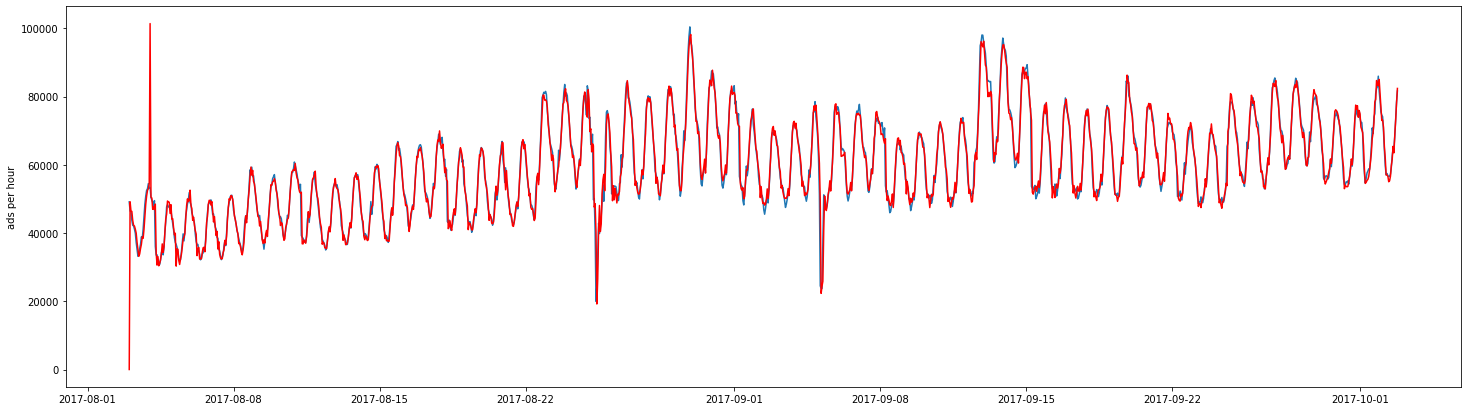

In [ ]:
train_df['pred'] = invboxcox(best_model.fittedvalues, lmbd)

plt.figure(figsize=(25,7))
plt.plot(train_df['Date'], train_df['ads'])
plt.plot(train_df['Date'], train_df['pred'], color='r')
plt.ylabel('ads per hour')
plt.show()

### Восстановление прогноза для test

In [ ]:
test_df['pred'] = invboxcox(best_model.forecast(test_df.shape[0]), lmbd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


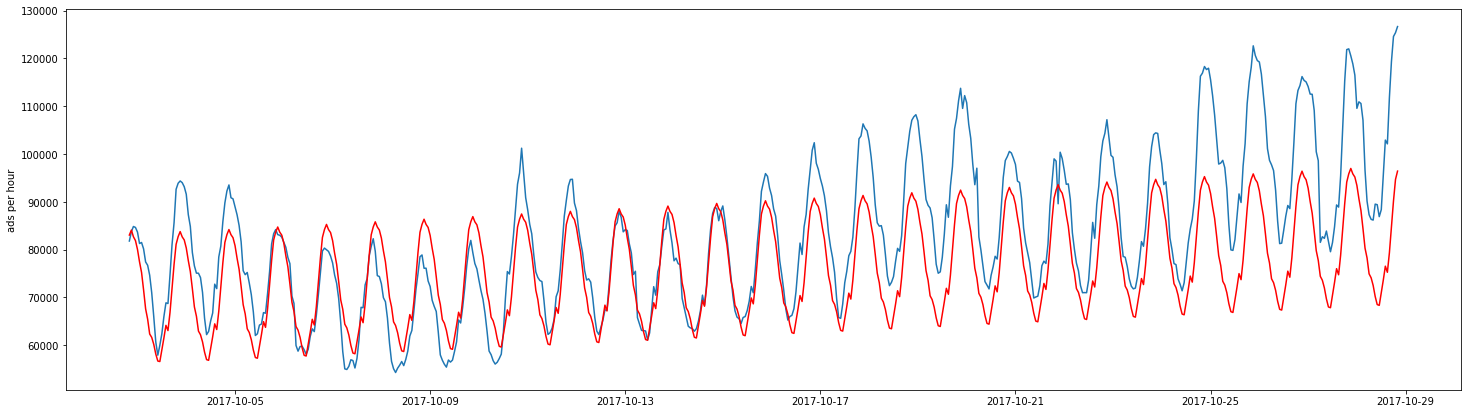

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(test_df['Date'], test_df['ads'])
plt.plot(test_df['Date'], test_df['pred'], color='r')
plt.ylabel('ads per hour')
plt.show()

In [ ]:
print(f"MAPE SARIMAX: {round(mean_absolute_percentage_error(test_df['ads'], test_df['pred']) * 100, 2)}%")

MAPE SARIMAX: 9.91%
